Propagating Light
==============


This notebook shows examples of using `aotools` to do the following:
- Create a complex wave from an aberrated wavefront
- Propagate a complex wave physically


In [1]:
import numpy
import matplotlib.pylab as plt
from tqdm import tqdm, trange, tqdm_notebook
from astropy.io import fits
%matplotlib inline
import aotools
from aotools.turbulence import infinitephasescreen
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.colors as colors
from aotools.turbulence.infinitephasescreen import PhaseScreenKolmogorov
j = 0+1j

First we need to create a phase screen object, similar to the one used in teh phase screen notebook.

In [2]:
# Set up parameters for creating phase screens
nx_size = 64
D = 1.
pxl_scale = D/nx_size
r0 = 0.32
L0 = 100
wind_speed = 10 #m/s - just arbitrarily set
stencil_length_factor = 32
wavelength = 500e-9

# Create the phase screen object using aotools
phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0, stencil_length_factor=stencil_length_factor)

Scintillation
--------------

In [3]:
wavefront = numpy.exp(j*phase_screen.scrn) # Convert the wavefront to a complex amplitude

I = numpy.abs(wavefront)**2 # Scintillation intensity patterns

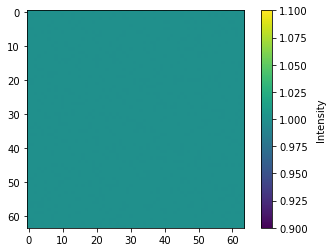

In [4]:
plt.figure()
plt.imshow(I)
cbar = plt.colorbar()
cbar.set_label('Intensity', labelpad=8)

As expected, adding a phase aberration has no effect on the distribution of light across a pupil.Now lets propagate the phase screen and see what happens

In [5]:
propagation_distance = 10000 # 10 km
propagated_wavefront = aotools.opticalpropagation.angularSpectrum(wavefront, wavelength, pxl_scale, pxl_scale, propagation_distance)

In [6]:
I = numpy.abs(propagated_wavefront)**2 # Scintillation intensity patterns

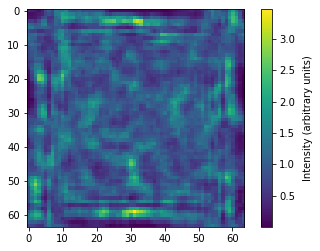

In [7]:
plt.figure()
plt.imshow(I)
cbar = plt.colorbar()
cbar.set_label('Intensity (arbitrary units)', labelpad=8)

We have an intensity pattern develop across the beam. This is known as scintillation. We can see how this phenomena appears and evolves as light propagates:

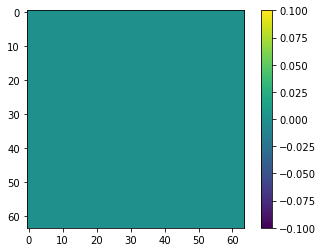

In [8]:
# Video of moving a phase screen
fig, ax = plt.subplots()
image = ax.imshow(numpy.zeros((64, 64)))
fig.colorbar(image)

def init():
    image.set_data(numpy.zeros((64, 64)))
    return (image,)

def animate(i):
    propagation_distance=i*25
    propagated_wavefront = aotools.opticalpropagation.angularSpectrum(wavefront, wavelength, pxl_scale, pxl_scale, propagation_distance)
    I = numpy.abs(propagated_wavefront)**2
    image.set_data(I)
    image.autoscale()
    ax.set_title("Propagation distance = %.1f km" % (propagation_distance/1000.))
    return (image,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=20, 
                               blit=True)

In [9]:
HTML(anim.to_html5_video())

Scintillation Statistics
-------------------------

We can also explore the statistics of these scintillation patterns. To do these we will need to create a large sample of phase screens and measure statistical properties of the set of phase screens. This is similar to the previous analysis to calculate the Zernike power spectrum of the phase of the phase screens.

In order to calculate the power spectrum of the scintillation patterns we can use a fourier transform, the `aotools.fouriertransform.ft2` function allows us to specify the spatial scale of the input scintillation pattern and normalise the spatial scales for easy interpretation of the results.

In [10]:
# Generate a large set of phase screens
N_scrns = 1000
propagation_distance = 10000

phase_screens = numpy.zeros((N_scrns, nx_size, nx_size))
Is = numpy.zeros_like(phase_screens)
powerspec = numpy.zeros_like(phase_screens)
for i in tqdm(range(N_scrns)):
    phase_screens[i] = PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0, stencil_length_factor=stencil_length_factor).scrn
    Is[i] = numpy.abs(aotools.opticalpropagation.angularSpectrum(numpy.exp(j*phase_screens[i]), 500e-9, pxl_scale, pxl_scale, propagation_distance))**2
    powerspec[i] = abs(aotools.fouriertransform.ft2(Is[i], D/nx_size))**2

100%|██████████| 1000/1000 [19:00<00:00,  1.14s/it] 


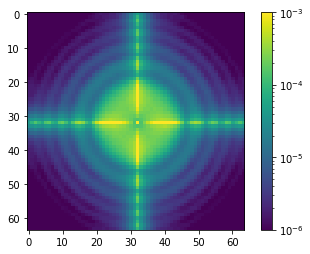

In [11]:
# Plot 2d irradiance power spectrum
plt.figure()
plt.imshow(powerspec.mean(0), norm=colors.LogNorm(1e-6,1e-3))
cbar = plt.colorbar()

Whilst the structure of the scintillation patterns are clearly visible, there is also a cross across the whole pattern. This is due to the square shape of the wavefront which is being propagated. These can be seen in the individual scintillation pattern as fringes around the edge of the pattern. This presents another reason to oversample phase screens relative to an area of interest in order to avoid simulation results picking up these artifacts.

Another point to note is the scintillation pattern itself is circularly symmetric. So another view of this pattern can be generated by averaging around the pattern. The `azimuthal_average` function built into aotools allows us to do this easily and then compare the results against the theoretical power spectrum for this regime.

In [12]:
# Take azimuthal avg of 2d spatial power spectrum to compare with theory
powerspec_1d = aotools.azimuthal_average(powerspec.mean(0))

In [13]:
spatial_scales = numpy.fft.fftshift(numpy.fft.fftfreq(nx_size, d=D/nx_size))[int(nx_size/2)+1:] # Fourier space coordinates

In [14]:
# Theoretical power spectrum
def W(f, z, cn2, wvl=500e-9):
    '''
    Spatial power spectrum of irradiance fluctuations (see Tokovinin 2002 for more detail)

    Assumes Kolmogorov turbulence and weak perturbation limit.
    '''
    return 3.9e-2 * (2*numpy.pi/wvl)**2 * cn2 * f**(-11/3) * (numpy.sin(numpy.pi * wvl * z * f**2))**2

W_th = W(spatial_scales, propagation_distance, aotools.r0_to_cn2(r0))

(0.0, 30.0)

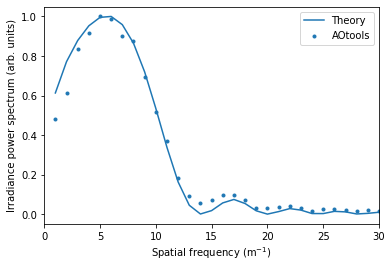

In [15]:
plt.figure()
plt.plot(spatial_scales, W_th/W_th.max(), label='Theory')
plt.scatter(spatial_scales, powerspec_1d[1:]/powerspec_1d[1:].max(), marker='.', label='AOtools')
plt.xlabel('Spatial frequency (m$^{-1}$)')
plt.ylabel('Irradiance power spectrum (arb. units)')
plt.legend(loc=0)
plt.xlim(0,30)